# Face Generation - Part 2

The objective of this second part of the project face generation is to redesign the GAN-architecture from part 1 and improve the image quality and image sizes.

We need high-quality and higher-resolution images for training the improved GAn in order to have improved generated images. [CelebA-128](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a dataset with 200k celebrities images,  having 128x128 pixels images and is used for this second part. We need to pre-process the data again.

Plan of attack
- download complete image CelebA-128 
- visualize 128x128 images
- apply facial landmark to select faces
- discard images with no landmark to reduce training input variance
- zoom to face/crop and resample to 128x128  
- use model trained in part 1 to with downscaled 32x32 to compare results
- add layers one by one and retrain to increase image sizes



In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [2]:
import cv2
import numpy as np
import dlib

cap = cv2.VideoCapture(0)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)


    cv2.imshow("Frame", frame)

    key = cv2.waitKey(1)
    if key == 27:
        break

ModuleNotFoundError: No module named 'dlib'

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """   
    
    # TODO: Implement function and return a dataloader
    num_workers = 0
    
    # perform data transform WITHOUT DATA AUGMENTATION for training data
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    image_dataset = datasets.ImageFolder(data_dir, transform=transform)                                           
                                               
    data_loader = torch.utils.data.DataLoader(dataset=image_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

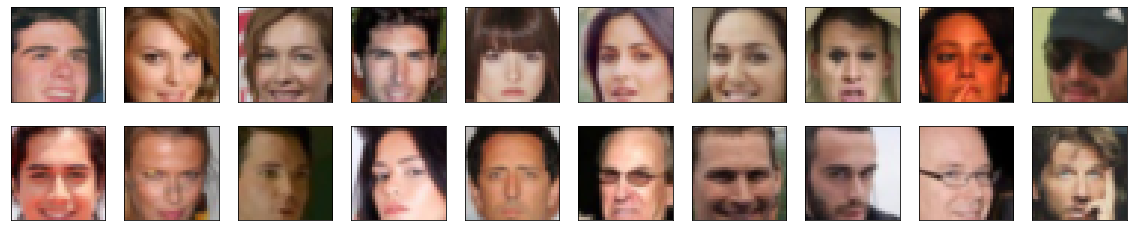

In [6]:
# helper display function
def imshow(img):
    #convert tensor to numpy array and scale pixel values to RGB uint8
    npimg = img.numpy()*255
    npimg = npimg.astype(np.uint8)

    #permute matrix
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(0.9843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        #out = F.tanh(out) # yields  warning
        out = torch.tanh(out)
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
#Weight initialization see
#https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

import torch.nn.init as init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    mean = 0
    std = 0.02

    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight.data, mean, std)
        if m.bias is not None:
            init.normal_(m.bias.data, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight.data, mean, std)
        if m.bias is not None:
            init.normal_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean, std)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.normal_(m.weight.data, mean, std)
        init.normal_(m.bias.data, 0)

In [14]:
def weights_init_kaiming(m):
    for m in m.modules():
        if isinstance(m, (nn.Conv2d,nn.ConvTranspose2d)):
            #print(m.weight)
            nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.normal_(m.weight.data, mean=1, std=0.02)
            nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')


## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    #todo try with MSEloss()
    #criterion = nn.MSELoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
lr_g = 0.0002 # learning rate generator
lr_d = 0.1 * lr_g

beta1=0.5
beta2=0.999

In [20]:
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr_d , [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g , [beta1, beta2])

In [21]:
# Implementing adaptive learning rates

import torch.optim as optim

#>>> # Assuming optimizer uses lr = 0.5 for all groups
#>>> # lr = 0.05     if epoch < 30
#>>> # lr = 0.005    if 30 <= epoch < 60
#>>> # lr = 0.0005   if 60 <= epoch < 90
#>>> # ...
#>>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
# the initial lr decayed by gamma every step_size epochs
#>>> for epoch in range(100):
#>>>     train(...)
#>>>     validate(...)
#>>>     scheduler.step()

lr_scheduler_d = optim.lr_scheduler.StepLR(d_optimizer, step_size=20, gamma=0.9)
lr_scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=20, gamma=0.9)

In [22]:
#for testing only
print('Epoch {}, lr {}'.format(0, d_optimizer.param_groups[0]['lr']))
print('Epoch {}, lr {}'.format(0, g_optimizer.param_groups[0]['lr']))

Epoch 0, lr 2e-05
Epoch 0, lr 0.0002


In [23]:
#for epoch in range(1, 25):
#    lr_scheduler_g.step()
#    print('Epoch {}, lr {}'.format(
#        epoch, g_optimizer.param_groups[0]['lr']))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
import time

In [25]:
RESTART = True
if RESTART == True:
    print('Initializing training!')
    #Arrays for plotting training performance
    #Avoid re-initialization if training is resumed with again N_EPOCHS!
    #train_loss_history = []
    #valid_loss_history #= []
    #valid_loss_min = np.Inf 
else:
    print('Resuming training!')
    model_transfer.load_state_dict(torch.load('gan-model-D.pt'))
    model_transfer.load_state_dict(torch.load('gan-model-G.pt'))
    #valid_loss_min = loadvalidlossmin('transfer_lossmin.p')

Initializing training!


In [26]:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
# move z to GPU if available
if train_on_gpu:
    fixed_z = fixed_z.cuda()

          

def train(D, G, n_epochs, modelfile_g, modelfile_d, print_every=8*50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    print('Initial learning rates: lr_d = {} and lr_g = {}'.format(d_optimizer.param_groups[0]['lr'], g_optimizer.param_groups[0]['lr']))
    
    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance

    #we want to measure the time for overall training
    start_training = time.time()
    # epoch training loop
    for epoch in range(n_epochs):

        #we want to measure the time for one epoch
        start_epoch = time.time()
        
        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z).detach()

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))      
        

      
        # adaptive learning rate
        lr_scheduler_d.step()         
        lr_scheduler_g.step()           
        print('Adjusted learning rates: lr_d = {} and lr_g = {}'.format(d_optimizer.param_groups[0]['lr'], g_optimizer.param_groups[0]['lr']))

        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        
        end_epoch = time.time()
        hours_epoch, rem_epoch = divmod(end_epoch-start_epoch, 3600)
        minutes_epoch, seconds_epoch = divmod(rem_epoch, 60)
        print("Epoch training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours_epoch),int(minutes_epoch),seconds_epoch))
        #time.strftime("%H:%M:%S", time.gmtime(n)) 


    end_training = time.time()
    hours_training, rem_training = divmod(end_training-start_training, 3600)
    minutes_training, seconds_training = divmod(rem_training, 60)
    print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours_training),int(minutes_training),seconds_training))

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    print('Training samples saved.')
    
    #Save models
    torch.save(D.state_dict(), modelfile_d)
    torch.save(G.state_dict(), modelfile_g)
    print('final models saved in ', modelfile_g,' and ', modelfile_d)
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs, 'gan-model-G.pt', 'gan-model-D.pt')

Initial learning rates: lr_d = 2e-05 and lr_g = 0.0002
Epoch [    1/  100] | d_loss: 1.8841 | g_loss: 0.3778
Epoch [    1/  100] | d_loss: 1.4954 | g_loss: 0.5350
Adjusted learning rates: lr_d = 2e-05 and lr_g = 0.0002
Epoch training time: 00:00:42.18
Epoch [    2/  100] | d_loss: 1.3970 | g_loss: 0.7465
Epoch [    2/  100] | d_loss: 1.3206 | g_loss: 0.8246
Adjusted learning rates: lr_d = 2e-05 and lr_g = 0.0002
Epoch training time: 00:00:42.69
Epoch [    3/  100] | d_loss: 1.3862 | g_loss: 0.7842
Epoch [    3/  100] | d_loss: 1.3702 | g_loss: 0.7901
Adjusted learning rates: lr_d = 2e-05 and lr_g = 0.0002
Epoch training time: 00:00:43.85
Epoch [    4/  100] | d_loss: 1.3677 | g_loss: 0.7970
Epoch [    4/  100] | d_loss: 1.3577 | g_loss: 0.8049
Adjusted learning rates: lr_d = 2e-05 and lr_g = 0.0002
Epoch training time: 00:00:45.08
Epoch [    5/  100] | d_loss: 1.3762 | g_loss: 0.7883
Epoch [    5/  100] | d_loss: 1.3792 | g_loss: 0.7705
Adjusted learning rates: lr_d = 2e-05 and lr_g = 

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
len(samples)

In [ ]:
_ = view_samples(1, samples)

In [ ]:
_ = view_samples(2, samples)

In [ ]:
_ = view_samples(3, samples)

In [ ]:
_ = view_samples(10, samples)

In [ ]:
_ = view_samples(20, samples)

In [ ]:
_ = view_samples(30, samples)

In [ ]:
_ = view_samples(40, samples)

In [ ]:
_ = view_samples(50, samples)

In [ ]:
_ = view_samples(60, samples)

In [ ]:
_ = view_samples(70, samples)

In [ ]:
_ = view_samples(80, samples)

In [ ]:
_ = view_samples(90, samples)

In [ ]:
_ = view_samples(-1, samples)

In [ ]:
#reload model
D.load_state_dict(torch.load('gan-model-D.pt'))
G.load_state_dict(torch.load('gan-model-G.pt'))

### Generate new images with a new random z

In [ ]:
# Let's generate a new set of pictures!
# Create a new latent vector z2
z2 = np.random.uniform(-1, 1, size=(sample_size, z_size))
z2 = torch.from_numpy(z2).float()
samples2 = []
if train_on_gpu:
    z2 = z2.cuda()

In [ ]:
G.eval() # for generating samples
samples_z2 = G(z2)
samples2.append(samples_z2)

_ = view_samples(-1, samples2)

### Latent vector arithmetics

In [ ]:
# let us do some latent vector arithmetics! 

#interpolate/morph between two image sets by change weight1 between 0 and 1
weight = 0.5
z_interpol = (weight*fixed_z + (1-weight)*z2)/2
samples_interpol = []
samples_z_interpol = G(z_interpol)
samples_interpol.append(samples_z_interpol)

_ = view_samples(-1, samples_interpol)


The interpolated images/faces are very similar to each other, that is a remarkable result! This happens even if generate a new set of images with a new random z2-vector. The images still look similar!

## Training without discriminator label smoothing

Until now, all the training was done with applying label smoothing with a factor 0.9. I wanted to see myself what happens how well my model train, what images will it generate after 100 epochs. So let's check first the losses:

![Training Losses without discriminator label smoothing](img/LossesWithoutSmoothing.png)

I was quite surprised, when I checked this plot and compared it to the previous loss data plot (with smoothing=0.9)! Shouldn't the model be less stable? What about generated image quality? Let's check next!

In [ ]:
#Let's compare the generated images without applying label smoothing
with open('train_samples_woLabelSmoothing.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(90, samples)

The generated images without applied smoothing are similar in quality to the generated images with applied smoothing. 

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
- The dataset is biased by training the model mostly with white faces. For that reason, the model itself learns to generate mostly white faces. The model is trained to learn what is provided by the training input images. If we would train the model with faces all images with faces having sun-glasses, the model would generate faces with sun-glasses as well. Furthermore, GANs tend to generate images with less variation. This is due the batch-oriented training: the losses are calculated and summed up through batch. Then the overall batch losses are back-pgropagated to adapt the gradients. Furthermore the generated images improve with a reduced input training image variance, i.e. sorting out input faces with sun-glasses or avoiding input images with hats help to improve generated image quality while keeping the network architecture untouched. The more the input complexity is reduced, or the less features the network needs to train, the smaller is the required network capacity and therefore the smaller and simpler the network itself. On the other hand, the more versatile the training images are, the more versatile the generated will be. This comes at the cost of a bigger network with all its implications.
- If the model is designed too small, the capacity of the model would not suffice to train all the features from all the input images. As a consequence, the model is generating inferior images. Increasing the model size increases the capacity as well, but also the training time and the risk for mode collapse. On the other hand, when designed carefully, the larger model provides superior images. When considering the generated images show acceptable results: we see clearly human faces, some are even good-looking!
- The optimizer ADAM with the same settings as the DCGAN was chosen. The number of epochs required are directly depending on the learning rate chosen: with a lr=0.0002, the model is already trained after 10 epochs, such that the gained improvement for an additional training during 10 Epochs is marginal. For the same result and with a learning rate ten times smaller, a training period of 100 epochs is required. Investigation on decaying learning rate was done as well, see GAN design considerations: it is a bit surprizing to see the network getting unstable even though the learning rate is decaying constantly. We can watch the discriminator going down and the generator losses getting higher. Also the generated image quality seems to worse after 90 Epochs...



### GAN design considerations

- [x] training without and with label smoothing of 0.9 was done, images qualities were compared. The results are a bit the opposite what I was expecting. See comments above.
- [x] the weight initialization is crucial for the stability!
- [x] applied batch norm to generator and discriminator
- [x] apply smaller learning rate to the discriminator than for the generator for improved stability. A factor of 10 was chosen.
- [x] Upper bound of a constant learning rate for the discriminator: 0.0002, model generates acceptable images after 70-100 Epochs. Model showed first signs of instability after ~90 Epochs. 
- [x] Lower bound of a constant learning rate for the discriminator: 0.00001, generated images are poor even after 100 epochs. At least 100 more epochs recomended.     
- [x] apply change betas from ADAM. beta1=0.5, beta2=0.999 
- [x] apply decaying learnig-rate by using pytorch built-in method StepLR() for reasonable training time, improved convergence and generated image quality. On the first attempt, the generated images were disappointing and unexpected, even after 100 Epochs and obviously inferior to the training of the models with constant learning rates. The step_size=1 and the gamma=0.9 were forcing the learning rate way too fast down. The final learning rates were lr_g = 5.3e-9, lr_d = 5.31e-10. Obviously the learning stopped too early by forcing the learning rates closer to zero. A priori, we do not know exactly when we should stop further training models. Several, time-consuming iterations are required in order to figure out the optimium. I think it is worth to further investigate on decaying or even cycling learning rates.
- [x] Added generation of images without the need to re-train the network
- [x] Added a new set of images generated
- [x] Added image-dataset interpolation/morphing with latent vector arithmetics 
- [ ] Cyclic learning rates
- [x] saving/loading models 
- [x] resume training (using models loading)
- [x] training time measurement
- [ ] add animated training sample image
- [ ] add animated morphing using latent vector arithmetics
- [ ] saving/loading learning rates for resuming training
- [ ] generate images with a new z-vectors or z-vector arithmetic to interpolate between different pictures or to generate controlled new ones.
- [ ] increase generated image size to 64, 128, 256
- [ ] Another promising approach is the ProGAN, the progressive growing GAN with a lot of good new techniques to improve quality of the generated images, to improve stability. highly recommended to investigate!
- [ ] How can we benchmark a GAN and its generated images? Could we design a neural network that is able to assess the generated images in an unsupervised manner? The Frechet Inception Distance (FID) could be way the forward. See link below!
- ...


I have added a few papers / articles which I had a read
- [Must-Read Papers on GANs](https://towardsdatascience.com/must-read-papers-on-gans-b665bbae3317)
- [GAN — Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)
- [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196)
- [Avoiding the vanishing gradients problem using gradient noise addition](https://towardsdatascience.com/avoiding-the-vanishing-gradients-problem-96183fd03343)
- [Adaptive - and Cyclical Learning Rates using PyTorch](https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee)
- [GAN — Some cool applications of GANs](https://medium.com/@jonathan_hui/gan-some-cool-applications-of-gans-4c9ecca35900)
- [How to Implement the Frechet Inception Distance (FID) for Evaluating GANs](https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/)





### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.